Analysis plan here: https://docs.google.com/document/d/1BaL9-Y8hVEuc0Uwobndrl1KwFFSfJh75HV5vHx5MrtQ/edit?usp=sharing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import snpytools as snpy
def q(sql):
    return snpy.df_from_presto(sql, user_name = 'devon.bancroft')
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn.linear_model import Ridge, Lasso
rreg = Ridge()
lasso = Lasso()
from sklearn.model_selection import cross_val_score
from scipy.stats import probplot
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

## Goal: predict whether a user will come back on their 7th day after install (D7RR) based on JUST our actions, and not a users actions. In this case, it means what kinds of pushes we sent to them

Model 1 (below) - based on how many pushes we send in each content category, and each push type

### Grabbing sent count by category for days 0 through 7 for new users for the month of November. Also, open count by day and whether the user was active that day. Later, I'll exclude all info for D7 except for whether they were active (i.e. whether they were part of D7RR or not)

In [2]:
start_date = '2019-11-01'
end_date = '2019-12-07'
install_end_date = '2019-11-30'
article_start_date = '2019-10-25'
article_end_date = '2019-12-15'
sql = f'''SELECT
   a.user_id,
   a.install_dt,
   a.network_name,
   a.platform,
   a.day,
   a.dt,
   COALESCE(b.sent_count, 0) as sent_count,
   COALESCE(action.received_push, 0) as open_count,
   COALESCE(LIFESTYLE, 0) as LIFESTYLE,
   COALESCE(ENTERTAINMENT, 0) as ENTERTAINMENT,
   COALESCE(WORLD, 0) as WORLD,
   COALESCE(SCIENCE, 0) as SCIENCE,
   COALESCE(BIZ, 0) as BIZ,
   COALESCE(TECH, 0) as TECH,
   COALESCE(SPORTS, 0) as SPORTS,
   COALESCE(POLITICS,0) as POLITICS,
   COALESCE(NATIONAL, 0) as NATIONAL,
   COALESCE(UNKNOWN, 0) as UNKNOWN,
   COALESCE(scheduled, 0) as scheduled,
   COALESCE(breaking, 0) as breaking,
   COALESCE(targetedPush, 0) as targetedPush,
   (
   CASE
      WHEN
         c.user_id IS NULL
      THEN
         0
      ELSE
         1
   END
) as active_day
FROM
   (
      SELECT
         user_id,
         install_dt,
         platform,
         network_name,
         dt,
         date_diff('day', date_parse(install_dt, '%Y-%m-%d'), date_parse(dt, '%Y-%m-%d')) as day
      FROM
         (
            SELECT
               user_id,
               date_format(from_unixtime(creation_timestamp), '%Y-%m-%d') as install_dt,
               network_name,
               platform
            from
               daily_user_installs
            where
               dt BETWEEN '{start_date}' AND '{install_end_date}'
               AND country = 'US'
               AND mod(user_id, 10) = 5
               AND language = 'en'
               AND user_id IN
               (
                  SELECT
                     id
                  from
                     users
                  where
                     dt = '{end_date}'
                     and j(profile, '$.pushNotificationPermission') = '1'
               )
         )
         a
         CROSS JOIN
            (
               SELECT
                  date as dt
               from
                  analytics.dates
               WHERE
                  date between '{start_date}' AND '{end_date}'
            )
            b
      where
         date_diff('day', date_parse(install_dt, '%Y-%m-%d'), date_parse(dt, '%Y-%m-%d')) between 0 and 7
   )
   a
   LEFT JOIN
      (
         SELECT
            user_id,
            dt,
            count(distinct push_id) as sent_count
         from
            smartnews.push_episodes
         WHERE
            dt between '{start_date}' AND '{end_date}'
            AND edition = 'en_US'
            AND mod(user_id, 10) = 5
         GROUP BY
            1, 2
      )
      b
      on b.user_id = a.user_id
      AND b.dt = a.dt
LEFT JOIN
         (
            SELECT
               user_id,
               dt,
               count(*) as received_push
            from
               actions
            WHERE
               dt between '{start_date}' AND '{end_date}'
               AND edition = 'en_US'
               AND mod(user_id, 10) = 5
               AND action = 'receivePush'
            GROUP BY
               1, 2
         )
         action
         on action.user_id = a.user_id
         AND action.dt = a.dt
   LEFT JOIN
      (
         SELECT DISTINCT
            dt,
            user_id
         from
            user_activities
         where
            dt between '{start_date}' AND '{end_date}'
            and edition = 'en_US'
      )
      c
      on a.user_id = c.user_id
      and c.dt = a.dt
   LEFT JOIN
      (
         SELECT
            user_id,
            dt,
            count_if(cat = 'EN_US_LIFESTYLE') as LIFESTYLE,
            count_if(cat = 'EN_US_ENTERTAINMENT') as ENTERTAINMENT,
            count_if(cat = 'EN_US_WORLD') as WORLD,
            count_if(cat = 'EN_US_SCIENCE') as SCIENCE,
            count_if(cat = 'EN_US_BUSINESS') as BIZ,
            count_if(cat = 'EN_US_TECHNOLOGY') as TECH,
            count_if(cat = 'EN_US_SPORTS') as SPORTS,
            count_if(cat = 'EN_US_POLITICS') as POLITICS,
            count_if(cat = 'EN_US_NATIONAL') as NATIONAL,
            count_if(cat = 'UNKNOWN') as UNKNOWN
         FROM
            (
               SELECT DISTINCT
                  user_id,
                  dt,
                  sent_link_url,
                  cat
               from
                  smartnews.push_episodes ep
                  INNER JOIN
                     (
                        SELECT
                           url,
                           array_min(category) as cat
                        from
                           articles
                        WHERE
                           dt between '{article_start_date}' AND '{article_end_date}'
                           AND lang = 'EN'
                     )
                     cat
                     on cat.url = ep.sent_link_url
               WHERE
                  ep.dt between '{start_date}' AND '{end_date}'
                  AND edition = 'en_US'
                  AND mod(user_id, 10) = 5
                  AND sent_link_rank = 0
            )
         GROUP BY
            1,
            2
      )
      d
      on a.dt = d.dt
      AND a.user_id = d.user_id
LEFT JOIN
         (
            SELECT
             user_id,
               dt,
               count(DISTINCT CASE WHEN split(push_id,'::')[1] = 'scheduled' THEN push_id ELSE null END) as scheduled,
               count(DISTINCT CASE WHEN split(push_id,'::')[1] = 'breaking' THEN push_id ELSE null END) as breaking,
               count(DISTINCT CASE WHEN split(push_id,'::')[1] = 'personalizedBreaking' THEN push_id ELSE null END) as targetedPush
            from
               smartnews.push_episodes
            WHERE
               dt between '{start_date}' AND '{end_date}'
               AND edition = 'en_US'
               AND mod(user_id, 10) = 5
            GROUP BY
               1, 2
         )
         e
         on e.user_id = a.user_id
         AND e.dt = a.dt'''

In [3]:
df = snpy.df_from_presto(sql, user_name='d.bancroft')

SELECT a.user_id,
       a.install_dt,
       a.network_name,
       a.platform,
       a.day,
       a.dt,
       COALESCE(b.sent_count, 0) AS sent_count,
       COALESCE(action.received_push, 0) AS open_count,
       COALESCE(LIFESTYLE, 0) AS LIFESTYLE,
       COALESCE(ENTERTAINMENT, 0) AS ENTERTAINMENT,
       COALESCE(WORLD, 0) AS WORLD,
       COALESCE(SCIENCE, 0) AS SCIENCE,
       COALESCE(BIZ, 0) AS BIZ,
       COALESCE(TECH, 0) AS TECH,
       COALESCE(SPORTS, 0) AS SPORTS,
       COALESCE(POLITICS, 0) AS POLITICS,
       COALESCE(NATIONAL, 0) AS NATIONAL,
       COALESCE(UNKNOWN, 0) AS UNKNOWN,
       COALESCE(scheduled, 0) AS scheduled,
       COALESCE(breaking, 0) AS breaking,
       COALESCE(targetedPush, 0) AS targetedPush,
       (CASE
            WHEN c.user_id IS NULL THEN 0
            ELSE 1
        END) AS active_day
FROM
  (SELECT user_id,
          install_dt,
          platform,
          network_name,
          dt,
          date_diff('day', date_parse(install_d

In [4]:
df.shape

(688962, 22)

In [5]:
df.head(30)

,user_id,install_dt,network_name,platform,day,dt,sent_count,open_count,LIFESTYLE,ENTERTAINMENT,...,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush,active_day
0,113517045,2019-11-30,Android_DigitalTurbine_Cricket_RON,android,0,2019-11-30,3,0,1,0,...,1,1,0,0,0,0,3,0,0,1
1,113517045,2019-11-30,Android_DigitalTurbine_Cricket_RON,android,1,2019-12-01,5,0,0,1,...,0,0,0,2,2,0,4,1,0,0
2,113517045,2019-11-30,Android_DigitalTurbine_Cricket_RON,android,2,2019-12-02,6,0,0,0,...,0,0,0,5,1,0,4,2,0,0
3,113517045,2019-11-30,Android_DigitalTurbine_Cricket_RON,android,3,2019-12-03,8,0,1,0,...,2,0,0,4,0,0,4,4,0,0
4,113517045,2019-11-30,Android_DigitalTurbine_Cricket_RON,android,4,2019-12-04,5,0,0,0,...,0,0,0,3,1,1,4,1,0,0
5,113517045,2019-11-30,Android_DigitalTurbine_Cricket_RON,android,5,2019-12-05,8,0,0,0,...,0,0,0,3,4,1,4,4,0,0
6,113517045,2019-11-30,Android_DigitalTurbine_Cricket_RON,android,6,2019-12-06,11,0,0,0,...,1,0,0,2,5,1,4,7,0,0
7,113517045,2019-11-30,Android_DigitalTurbine_Cricket_RON,android,7,2019-12-07,7,0,1,0,...,1,0,0,1,4,0,4,3,0,0
8,113119035,2019-11-26,Android_DigitalTurbine_Verizon_Test,android,0,2019-11-26,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,113119035,2019-11-26,Android_DigitalTurbine_Verizon_Test,android,1,2019-11-27,5,0,2,0,...,1,0,0,2,1,1,4,1,0,0


In [6]:
df.describe()

,user_id,day,sent_count,open_count,LIFESTYLE,ENTERTAINMENT,WORLD,SCIENCE,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush,active_day
count,6.889620e+05,688962.000000,688962.000000,688962.000000,688962.000000,688962.000000,688962.000000,688962.000000,688962.000000,688962.000000,688962.000000,688962.000000,688962.000000,688962.000000,688962.000000,688962.000000,688962.000000,688962.000000
mean,1.117047e+08,3.500422,5.075678,0.209138,0.386226,0.128457,0.377202,0.301636,0.287660,0.053703,0.036104,2.401958,1.233997,0.206228,2.946537,1.694552,0.434589,0.280616
std,1.192959e+06,2.291281,3.343351,0.708109,0.707164,0.440116,0.660585,0.547085,0.584435,0.242640,0.253173,2.107358,1.250664,0.483310,1.674340,1.666932,1.136590,0.449301
min,1.094463e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.107026e+08,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.117465e+08,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,4.000000,1.000000,0.000000,0.000000
75%,1.127238e+08,6.000000,7.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,4.000000,2.000000,0.000000,4.000000,3.000000,0.000000,1.000000
max,1.136657e+08,7.000000,21.000000,128.000000,6.000000,5.000000,7.000000,5.000000,6.000000,4.000000,7.000000,13.000000,12.000000,5.000000,6.000000,7.000000,11.000000,1.000000


In [7]:
df.network_name.value_counts()

Organic                                         125309
Facebook Installs                               117919
Android_ironSource-AURA_US_Preload              107617
Android_DigitalTurbine_Verizon_RON               59992
Android_DigitalTurbine_Tracfone_RON              48499
Android_DigitalTurbine_Cricket_RON               46865
Adwords UAC Installs                             43785
Android_DigitalTurbine_Verizon_Test              42624
Android_DigitalTurbine_ATT_RON                   41824
Android_ironSource-AURA_US_OOBE                  11296
Android_DigitalTurbine_USCellular_RON             9504
Android_Samsung_Galaxy                            8520
Android_Liftoff_US                                6776
Android_DigitalTurbine_Verizon_35+                4731
Android_ironSource-AURA_US_OOBE_TMobile           3208
Android_Pinsight_US_Sprint_Preload                2712
Off-Facebook Installs                             2488
Untrusted Devices                                 1757
Android_ir

In [8]:
df.platform.value_counts()

android    627059
ios         61903
Name: platform, dtype: int64

In [9]:
df[(df.active_day==0)&(df.open_count>0)]

,user_id,install_dt,network_name,platform,day,dt,sent_count,open_count,LIFESTYLE,ENTERTAINMENT,...,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush,active_day


In [10]:
df[df.user_id == 112008955]

,user_id,install_dt,network_name,platform,day,dt,sent_count,open_count,LIFESTYLE,ENTERTAINMENT,...,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush,active_day
459093,112008955,2019-11-18,Organic,android,0,2019-11-18,5,0,0,0,...,1,0,0,3,1,0,1,4,0,1
478443,112008955,2019-11-18,Organic,android,1,2019-11-19,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
478615,112008955,2019-11-18,Organic,android,2,2019-11-20,11,0,0,0,...,0,0,0,9,0,0,4,3,4,0
478761,112008955,2019-11-18,Organic,android,3,2019-11-21,10,5,0,0,...,1,0,0,8,0,0,4,3,3,1
478856,112008955,2019-11-18,Organic,android,4,2019-11-22,8,0,0,0,...,3,0,0,2,2,1,4,0,4,1
478887,112008955,2019-11-18,Organic,android,5,2019-11-23,9,2,0,0,...,4,0,0,2,4,0,4,1,4,1
478904,112008955,2019-11-18,Organic,android,6,2019-11-24,10,1,0,0,...,1,0,0,6,1,2,4,3,3,1
478919,112008955,2019-11-18,Organic,android,7,2019-11-25,10,0,0,0,...,1,0,0,7,2,0,4,4,2,0


### Seems to be an outage on 11/19 for push_episodes

In [11]:
df[df.dt == '2019-11-19'].sent_count.value_counts()

0    23650
Name: sent_count, dtype: int64

In [12]:
df[df.dt == '2019-11-19'].open_count.value_counts()

0     20805
1      1777
2       645
3       229
4       113
5        41
6        20
7        10
8         6
11        1
10        1
9         1
18        1
Name: open_count, dtype: int64

In [13]:
df[df.dt == '2019-11-19']

,user_id,install_dt,network_name,platform,day,dt,sent_count,open_count,LIFESTYLE,ENTERTAINMENT,...,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush,active_day
59,111734485,2019-11-16,Facebook Installs,android,3,2019-11-19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65,111957125,2019-11-18,Android_Liftoff_US,android,1,2019-11-19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117,111379675,2019-11-14,Android_ironSource-AURA_US_Preload,android,5,2019-11-19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1523,113009295,2019-11-14,Android_ironSource-AURA_US_Preload,android,5,2019-11-19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1524,111725195,2019-11-16,Android_ironSource-AURA_US_Preload,android,3,2019-11-19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688780,111370065,2019-11-14,Adwords UAC Installs,android,5,2019-11-19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
688781,111408895,2019-11-14,Android_ironSource-AURA_US_Preload,android,5,2019-11-19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
688782,111482215,2019-11-14,Facebook Installs,android,5,2019-11-19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
688783,111430965,2019-11-14,Organic,android,5,2019-11-19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df.groupby('dt').sent_count.mean().sort_values(ascending=True)

dt
2019-11-19    0.000000
2019-11-02    2.603435
2019-11-01    3.083428
2019-11-22    3.463530
2019-11-30    3.480485
2019-11-03    3.654184
2019-11-09    3.904405
2019-11-28    3.905741
2019-11-26    3.935153
2019-11-27    3.968346
2019-11-23    4.056437
2019-11-05    4.365236
2019-12-01    4.498431
2019-11-08    4.513845
2019-11-10    4.714507
2019-11-17    4.884614
2019-11-11    4.978637
2019-12-04    4.989703
2019-11-29    5.047791
2019-11-12    5.242270
2019-11-13    5.293465
2019-11-07    5.307787
2019-12-02    5.529947
2019-11-24    5.532679
2019-11-21    5.790404
2019-11-16    5.821883
2019-11-20    5.897977
2019-11-25    6.339347
2019-11-04    6.413575
2019-11-15    6.503426
2019-12-07    6.533842
2019-11-18    7.248788
2019-12-05    7.293147
2019-11-14    7.347200
2019-12-03    7.378928
2019-11-06    8.261707
2019-12-06    9.178289
Name: sent_count, dtype: float64

In [15]:
df = df[~df.user_id.isin(df[(df.day==7)&(df.dt=='2019-11-19')].user_id)]

### Making sent count the mean for that day, as well as for Politics and National

In [16]:
df['sent_count'] = np.where(df.dt=='2019-11-19', round(df.sent_count.mean(),0), df.sent_count)

In [17]:
df.describe()

,user_id,day,sent_count,open_count,LIFESTYLE,ENTERTAINMENT,WORLD,SCIENCE,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush,active_day
count,6.667380e+05,666738.000000,666738.000000,666738.000000,666738.000000,666738.000000,666738.000000,666738.000000,666738.000000,666738.000000,666738.000000,666738.000000,666738.000000,666738.000000,666738.000000,666738.000000,666738.000000,666738.000000
mean,1.117222e+08,3.500436,5.228328,0.208464,0.391227,0.125021,0.379197,0.299930,0.291060,0.055241,0.036140,2.384958,1.242064,0.212443,2.956614,1.677188,0.438003,0.280579
std,1.208708e+06,2.291280,3.195463,0.706266,0.708153,0.431989,0.665477,0.543714,0.588295,0.245879,0.253444,2.090988,1.255231,0.489349,1.668630,1.655492,1.141814,0.449283
min,1.094463e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.106732e+08,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,1.118025e+08,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,4.000000,1.000000,0.000000,0.000000
75%,1.127606e+08,6.000000,7.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,4.000000,2.000000,0.000000,4.000000,3.000000,0.000000,1.000000
max,1.136657e+08,7.000000,21.000000,128.000000,6.000000,5.000000,7.000000,5.000000,6.000000,4.000000,7.000000,13.000000,12.000000,5.000000,6.000000,7.000000,11.000000,1.000000


In [18]:
df[df.dt=='2019-11-19']

,user_id,install_dt,network_name,platform,day,dt,sent_count,open_count,LIFESTYLE,ENTERTAINMENT,...,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush,active_day
59,111734485,2019-11-16,Facebook Installs,android,3,2019-11-19,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65,111957125,2019-11-18,Android_Liftoff_US,android,1,2019-11-19,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117,111379675,2019-11-14,Android_ironSource-AURA_US_Preload,android,5,2019-11-19,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1523,113009295,2019-11-14,Android_ironSource-AURA_US_Preload,android,5,2019-11-19,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1524,111725195,2019-11-16,Android_ironSource-AURA_US_Preload,android,3,2019-11-19,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688780,111370065,2019-11-14,Adwords UAC Installs,android,5,2019-11-19,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
688781,111408895,2019-11-14,Android_ironSource-AURA_US_Preload,android,5,2019-11-19,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
688782,111482215,2019-11-14,Facebook Installs,android,5,2019-11-19,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
688783,111430965,2019-11-14,Organic,android,5,2019-11-19,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df['POLITICS'] = np.where(df.dt=='2019-11-19', round(df.POLITICS.mean(),0), df.POLITICS)

In [20]:
df['NATIONAL'] = np.where(df.dt=='2019-11-19', round(df.NATIONAL.mean(),0), df.NATIONAL)

In [21]:
df['scheduled'] = np.where(df.dt=='2019-11-19', round(df.scheduled.mean(),0), df.scheduled)

In [22]:
df['breaking'] = np.where(df.dt=='2019-11-19', round(df.breaking.mean(),0), df.breaking)

### Exploratory data analysis

In [23]:
df.set_index('user_id').iloc[:,-14:-1].groupby('user_id').sum()

,LIFESTYLE,ENTERTAINMENT,WORLD,SCIENCE,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush
user_id,,,,,,,,,,,,,
109446335,4,0,5,5,3,2,0,26.0,12.0,3,32.0,18.0,2
109446355,1,0,0,1,0,0,0,0.0,0.0,0,1.0,0.0,0
109446375,0,0,0,0,0,0,0,0.0,0.0,0,0.0,0.0,0
109446385,3,1,5,5,3,1,1,23.0,13.0,5,32.0,18.0,0
109446425,3,1,5,5,3,1,1,23.0,13.0,5,32.0,18.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113665435,2,1,1,3,4,0,0,20.0,16.0,4,27.0,22.0,0
113665485,7,2,2,5,4,1,7,20.0,20.0,4,28.0,22.0,20
113665505,0,0,0,0,0,0,0,0.0,0.0,0,0.0,0.0,0


#### Distribution of number of sent pushes per user over D0-D7

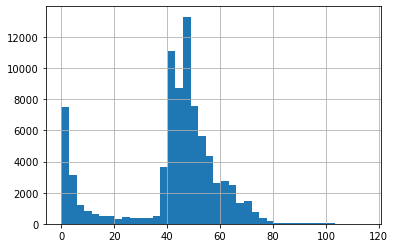

In [24]:
df.groupby('user_id').sent_count.sum().hist(bins=40)

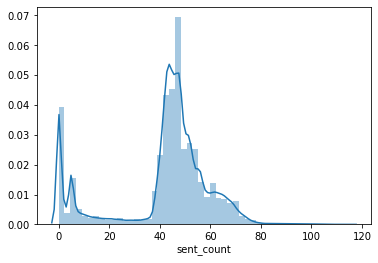

In [25]:
sns.distplot(df.groupby('user_id').sent_count.sum())

Why so many 0s? This is filtered to users with push enabled by 12/7

In [26]:
df.groupby('user_id').sent_count.sum().value_counts()[0] / df.groupby('user_id').sent_count.sum().value_counts().sum()

0.07383105822517573

~7% of users had no pushes recorded as sent during first 7 days

Was it an error from push_episodes? Did they open any pushes according to actions table?

In [27]:
np.count_nonzero(df[(df.sent_count==0)&(df.open_count>0)]['user_id'].unique())

26

A few errors, but it mostly looks correct

In [28]:
df.groupby('user_id').sent_count.sum().sort_values().head(15)

user_id
110549895    0.0
111086295    0.0
112226965    0.0
112329305    0.0
109978815    0.0
109742345    0.0
111086305    0.0
112329205    0.0
110446015    0.0
110445985    0.0
110656315    0.0
110656735    0.0
112292265    0.0
112938505    0.0
112227195    0.0
Name: sent_count, dtype: float64

In [29]:
df[df.user_id == 109896125]

,user_id,install_dt,network_name,platform,day,dt,sent_count,open_count,LIFESTYLE,ENTERTAINMENT,...,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush,active_day
417882,109896125,2019-11-03,Android_DigitalTurbine_Verizon_RON,android,4,2019-11-07,0.0,0,0,0,...,0,0,0,0.0,0.0,0,0.0,0.0,0,0
418463,109896125,2019-11-03,Android_DigitalTurbine_Verizon_RON,android,5,2019-11-08,0.0,0,0,0,...,0,0,0,0.0,0.0,0,0.0,0.0,0,0
431476,109896125,2019-11-03,Android_DigitalTurbine_Verizon_RON,android,0,2019-11-03,0.0,0,0,0,...,0,0,0,0.0,0.0,0,0.0,0.0,0,1
431610,109896125,2019-11-03,Android_DigitalTurbine_Verizon_RON,android,1,2019-11-04,0.0,0,0,0,...,0,0,0,0.0,0.0,0,0.0,0.0,0,0
431792,109896125,2019-11-03,Android_DigitalTurbine_Verizon_RON,android,2,2019-11-05,0.0,0,0,0,...,0,0,0,0.0,0.0,0,0.0,0.0,0,0
432012,109896125,2019-11-03,Android_DigitalTurbine_Verizon_RON,android,3,2019-11-06,0.0,0,0,0,...,0,0,0,0.0,0.0,0,0.0,0.0,0,0
473219,109896125,2019-11-03,Android_DigitalTurbine_Verizon_RON,android,6,2019-11-09,0.0,0,0,0,...,0,0,0,0.0,0.0,0,0.0,0.0,0,0
473439,109896125,2019-11-03,Android_DigitalTurbine_Verizon_RON,android,7,2019-11-10,0.0,0,0,0,...,0,0,0,0.0,0.0,0,0.0,0.0,0,0


Checked 5 different user_ids manually, and the results are all the same the same. The user has push permission turned on every day since their install date, yet we didnt send them any pushes. E.g. queries here: https://shib.smartnews.be/q/34d08f1b604b4facfd595f55a4522984 and here: https://shib.smartnews.be/q/3d64168b32325038c0672d1810641cae

Seems to be understood here: https://smartnews.slack.com/archives/C7H8YEQ22/p1578085487029800

In [30]:
zero_users = df.groupby('user_id').sent_count.sum() < 1

In [31]:
zero_users[zero_users]

user_id
109446375    True
109446695    True
109447085    True
109448495    True
109449015    True
             ... 
113664365    True
113664735    True
113665125    True
113665425    True
113665505    True
Name: sent_count, Length: 6155, dtype: bool

### Is there any pattern to users with zero sent count?

Install date for zero vs all

In [32]:
df['install_dt'] = pd.to_datetime(df.install_dt)

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


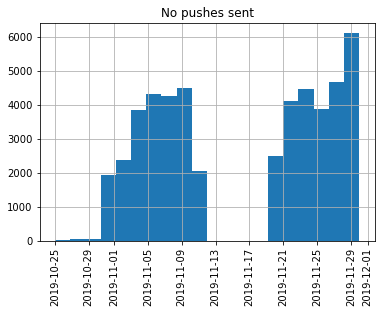

In [33]:
df[df.user_id.isin(zero_users[zero_users].index)].install_dt.hist(bins=20);
plt.xticks(rotation=90);
plt.title('No pushes sent');

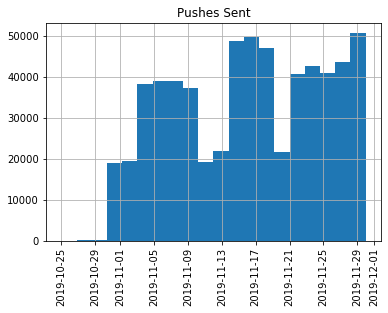

In [34]:
df[~df.user_id.isin(zero_users[zero_users].index)].install_dt.hist(bins=20);
plt.xticks(rotation=90);
plt.title('Pushes Sent'); 

Week of 12th had not users with 0 sent count?

How about install cohort?

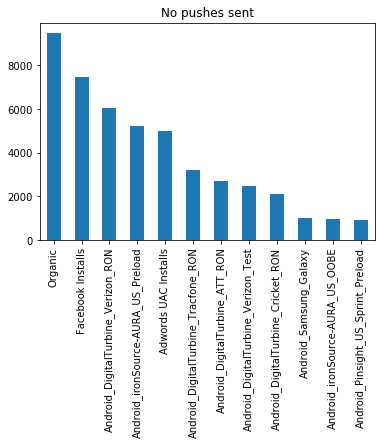

In [35]:
df[df.user_id.isin(zero_users[zero_users].index)].network_name.value_counts()[0:12].plot(kind='bar');
plt.title('No pushes sent');

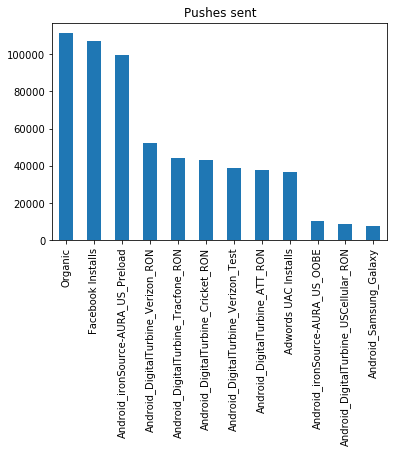

In [36]:
df[~df.user_id.isin(zero_users[zero_users].index)].network_name.value_counts()[0:12].plot(kind='bar');
plt.title('Pushes sent');

Looks about the same, slightly higher preloads

### Finding: 7% of new users with push enabled get 0 pushes. For now, not sure of reason

Removing users with 0 pushes

In [37]:
df.shape

(666738, 22)

In [38]:
df[~df.user_id.isin(zero_users[zero_users].index)].shape

(617651, 22)

In [39]:
df = df[~df.user_id.isin(zero_users[zero_users].index)].copy()

### Second look at distribution with 0 sent pushes removed

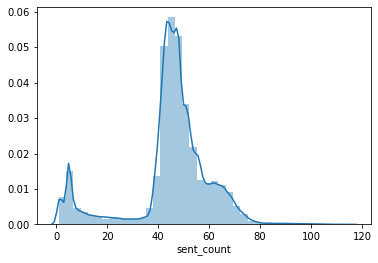

In [40]:
sns.distplot(df.groupby('user_id').sent_count.sum(), bins=40)

In [41]:
(df.groupby('user_id').sent_count.sum() < 40).mean()

0.16159614562691843

In [42]:
df.groupby('user_id').sent_count.sum().skew()

-0.9943876142547687

### Left skewed distribution. Lots of users, about 16%, get very few pushes in first week

In [43]:
df.iloc[:,8:18]

,LIFESTYLE,ENTERTAINMENT,WORLD,SCIENCE,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN
0,1,0,0,0,1,1,0,0.0,0.0,0
1,0,1,0,0,0,0,0,2.0,2.0,0
2,0,0,0,0,0,0,0,5.0,1.0,0
3,1,0,0,1,2,0,0,4.0,0.0,0
4,0,0,0,1,0,0,0,3.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...
688957,0,0,0,0,0,0,0,0.0,0.0,0
688958,1,0,1,0,0,0,0,3.0,2.0,0
688959,0,0,0,1,1,0,0,2.0,1.0,0
688960,0,0,0,0,0,0,0,0.0,0.0,0


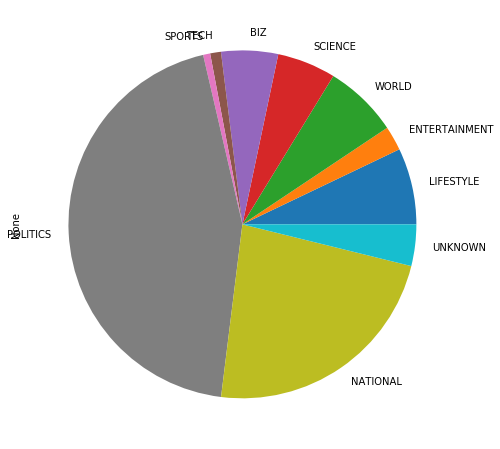

In [44]:
df.iloc[:,8:18].sum().plot(kind='pie', figsize=(12,8));

### 2/3rds of pushes are Politics and National

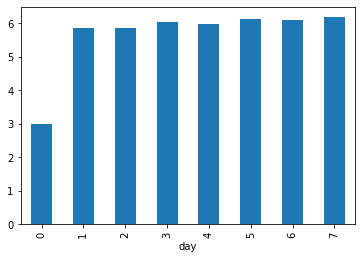

In [45]:
df.groupby('day').sent_count.mean().plot(kind='bar')

### Average on Day 0 around three, average for the other days all around 5 to 6

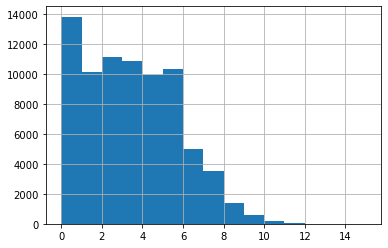

In [46]:
df[df.day==0].groupby('user_id').sent_count.sum().hist(bins=15)

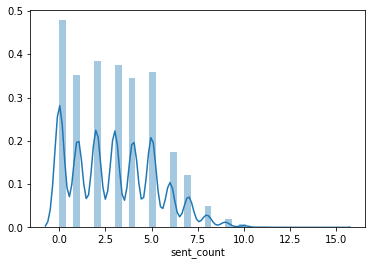

In [47]:
sns.distplot(df[df.day==0].groupby('user_id').sent_count.sum(), bins=40)

### Wide distribution of D0 sent count

In [48]:
df[df.user_id.isin(df[df.day==0].user_id)][df.day==7].groupby('user_id').active_day.mean()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


user_id
109446335    0
109446355    0
109446385    0
109446425    0
109446435    1
            ..
113665395    0
113665435    0
113665485    0
113665515    0
113665655    1
Name: active_day, Length: 77198, dtype: int64

In [49]:
df[df.user_id.isin(df[df.day==7].groupby('user_id').active_day.mean().index)][df.day==0].groupby('user_id').sent_count.sum()

user_id
109446335    7.0
109446355    1.0
109446385    7.0
109446425    7.0
109446435    7.0
            ... 
113665395    0.0
113665435    0.0
113665485    0.0
113665515    0.0
113665655    0.0
Name: sent_count, Length: 77198, dtype: float64

### Looking at users who don't have all D0 to D7 recorded

In [50]:
(df.groupby('user_id').day.sum() == 28).mean()

0.9998834362979369

### A few bits of bad data. Removing them

In [51]:
bad_users = df.groupby('user_id').day.sum() < 28

In [52]:
bad_users[bad_users]

user_id
109486905    True
109516585    True
109538545    True
109561715    True
109578405    True
109753095    True
109764835    True
109929795    True
110227415    True
Name: day, dtype: bool

In [53]:
df = df[~df.user_id.isin(bad_users[bad_users].index)].copy()

In [54]:
df.shape

(617612, 22)

In [55]:
df[df.user_id==109486905]

,user_id,install_dt,network_name,platform,day,dt,sent_count,open_count,LIFESTYLE,ENTERTAINMENT,...,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush,active_day


Getting rid of users without the full 7 days

Sent count on D0 vs active on D7

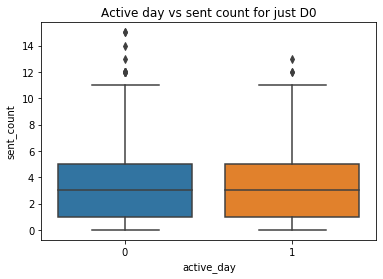

In [56]:
sns.boxplot(y = df[df.day==0].groupby('user_id').sent_count.sum(), x=df[
    df.day==7].groupby('user_id').active_day.mean());
plt.title('Active day vs sent count for just D0');

Not much difference

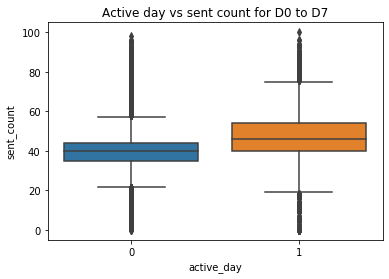

In [57]:
sns.boxplot(y = df[df.day<7].groupby('user_id').sent_count.sum(), x=df[
    df.day==7].groupby('user_id').active_day.mean());
plt.title('Active day vs sent count for D0 to D7');

### Plotting boxplot for number of pushes for each day D0-D6 vs acrtive on D7

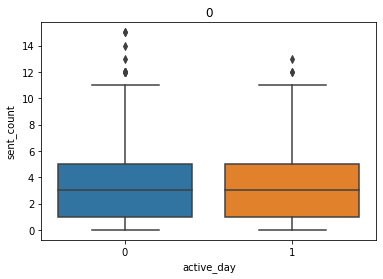

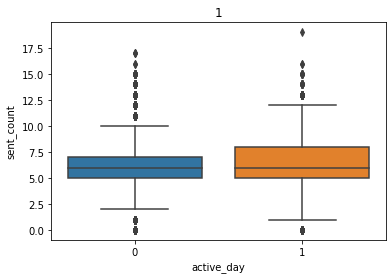

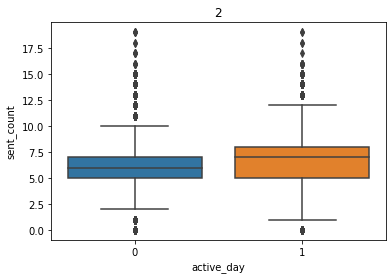

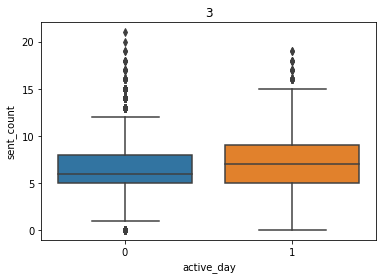

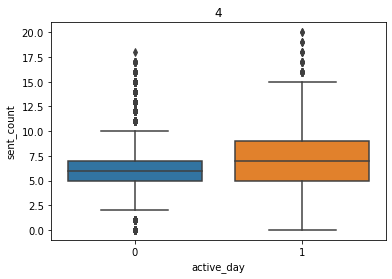

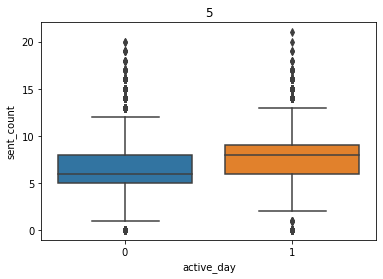

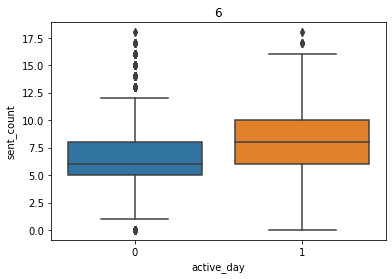

In [58]:
for i in range(0,7):
    plt.figure()
    plt.title(i)
    sns.boxplot(y = df[df.day==i].groupby('user_id').sent_count.sum(), x=df[
    df.day==7].groupby('user_id').active_day.mean());

### Finding: Unsurprisingly, as you get closer to D7, number of pushes sent becomes more important. 

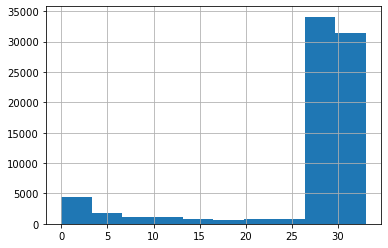

In [59]:
df[['user_id','scheduled','breaking','targetedPush']].groupby('user_id').scheduled.sum().hist()

In [60]:
np.mean(df.groupby('user_id').scheduled.sum() < 26)

0.14559208310665528

### For some reason 15% of new users aren't getting 4 scheduled pushes a day. I doubt that many people are adjusting their settings. Something to check on

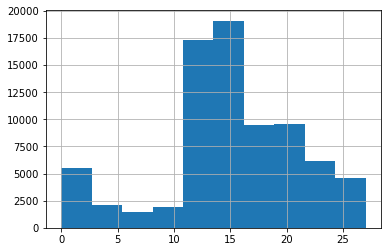

In [61]:
df[['user_id','scheduled','breaking','targetedPush']].groupby('user_id').breaking.sum().hist()

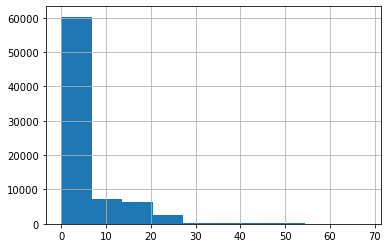

In [62]:
df[['user_id','scheduled','breaking','targetedPush']].groupby('user_id').targetedPush.sum().hist()

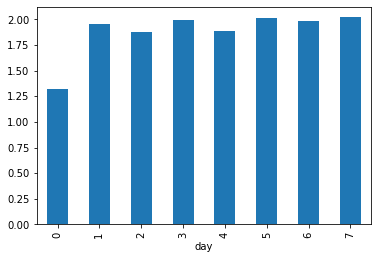

In [63]:
df[['user_id','scheduled','breaking','targetedPush', 'day']].groupby('day').breaking.mean().plot(kind='bar')

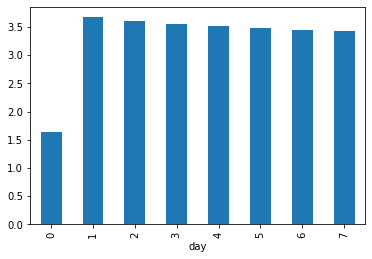

In [64]:
df[['user_id','scheduled','breaking','targetedPush', 'day']].groupby('day').scheduled.mean().plot(kind='bar')

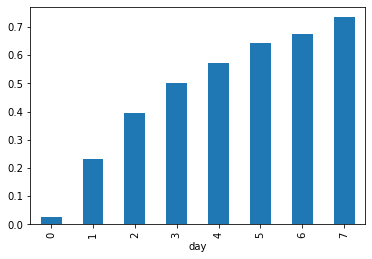

In [65]:
df[['user_id','scheduled','breaking','targetedPush', 'day']].groupby('day').targetedPush.mean().plot(kind='bar')

### Finding: Breaking and scheduled stay about steady on average day to day. Targeted ramps up as we collect user behavior, though still averages less than 1 by D7.  Breaking and Scheduled average around 3.5 and 2 respectively. 

### Current D7RR = ~16% 

In [66]:
df[df.day==7].active_day.mean()

0.16373928136576774

### Current average of ~5 pushes per day for new users (NOT counting local pushes)

In [67]:
np.mean(df.groupby('user_id').sent_count.mean())

5.643910501948506

In [68]:
df.groupby('user_id').sent_count.mean().std()

2.006602947409299

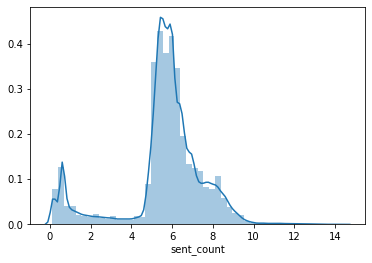

In [69]:
sns.distplot(df.groupby('user_id').sent_count.mean())

## Creating new dataframe to run simple model on push by category and type for D0 to D6 to predict D7R

In [70]:
df_new = pd.DataFrame(df['user_id'].unique()).rename({0:'user_id'}, axis=1)

In [71]:
pd.DataFrame(df[df.day != 7].groupby('user_id').sent_count.sum()).rename({'sent_count':'total_sent_count'}, axis=1)

,total_sent_count
user_id,
109446335,45.0
109446355,1.0
109446385,45.0
109446425,45.0
109446435,70.0
...,...
113665395,43.0
113665435,42.0
113665485,59.0


In [72]:
df_new = pd.merge(df_new, pd.DataFrame(df[df.day != 7].groupby('user_id').sent_count.sum()).rename({
    'sent_count':'total_sent_count'}, axis=1), on='user_id', how='left')

In [73]:
df[df.day !=7].set_index('user_id').iloc[:,-11:-1].groupby('user_id').sum()

,SCIENCE,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush
user_id,,,,,,,,,,
109446335,4,3,2,0,22.0,10.0,3,28.0,17.0,0
109446355,1,0,0,0,0.0,0.0,0,1.0,0.0,0
109446385,4,3,1,0,21.0,13.0,4,28.0,17.0,0
109446425,4,3,1,0,21.0,13.0,4,28.0,17.0,0
109446435,4,3,2,0,38.0,18.0,3,28.0,17.0,25
...,...,...,...,...,...,...,...,...,...,...
113665395,1,4,1,0,19.0,13.0,4,24.0,19.0,0
113665435,3,3,0,0,19.0,12.0,4,23.0,19.0,0
113665485,4,4,1,6,19.0,15.0,4,24.0,19.0,16


In [74]:
df_new.shape

(77202, 2)

In [75]:
df_new = pd.merge(df_new,df[df.day !=7].set_index('user_id').iloc[:,-11:-1].groupby('user_id').
                  sum(), on='user_id', how='left')

In [76]:
df[df.day==7][['user_id', 'active_day']].rename({'active_day':'D7R'}, axis=1)

,user_id,D7R
7,113517045,0
15,113119035,0
23,113100545,0
39,113012915,0
47,113328335,0
...,...,...
688957,111430965,0
688958,111439535,0
688959,111497695,0
688960,111583995,0


In [77]:
df_new = pd.merge(df_new,df[df.day==7][
    ['user_id', 'active_day']].rename({'active_day':'D7R'}, axis=1), on='user_id', how='left')

In [78]:
df.head()

,user_id,install_dt,network_name,platform,day,dt,sent_count,open_count,LIFESTYLE,ENTERTAINMENT,...,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush,active_day
0,113517045,2019-11-30,Android_DigitalTurbine_Cricket_RON,android,0,2019-11-30,3.0,0,1,0,...,1,1,0,0.0,0.0,0,3.0,0.0,0,1
1,113517045,2019-11-30,Android_DigitalTurbine_Cricket_RON,android,1,2019-12-01,5.0,0,0,1,...,0,0,0,2.0,2.0,0,4.0,1.0,0,0
2,113517045,2019-11-30,Android_DigitalTurbine_Cricket_RON,android,2,2019-12-02,6.0,0,0,0,...,0,0,0,5.0,1.0,0,4.0,2.0,0,0
3,113517045,2019-11-30,Android_DigitalTurbine_Cricket_RON,android,3,2019-12-03,8.0,0,1,0,...,2,0,0,4.0,0.0,0,4.0,4.0,0,0
4,113517045,2019-11-30,Android_DigitalTurbine_Cricket_RON,android,4,2019-12-04,5.0,0,0,0,...,0,0,0,3.0,1.0,1,4.0,1.0,0,0


In [79]:
# pd.DataFrame(df[df.day != 7].groupby('user_id').open_count.sum()).rename(
#     {'open_count':'total_open_count'}, axis=1)

In [80]:
# df_new = pd.merge(df_new,pd.DataFrame(df[df.day != 7].groupby('user_id').open_count.sum()).rename({
#     'open_count':'total_open_count'}, axis=1), on='user_id', how='left')

In [81]:
df_new.head()

,user_id,total_sent_count,SCIENCE,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush,D7R
0,113517045,46.0,3,4,1,0,19.0,13.0,3,27.0,19.0,0,0
1,113119035,31.0,0,2,1,0,12.0,5.0,1,24.0,7.0,0,0
2,113100545,33.0,0,2,2,0,13.0,5.0,1,25.0,8.0,0,0
3,113012915,36.0,2,2,2,0,14.0,6.0,1,28.0,8.0,0,0
4,113328335,40.0,1,3,1,3,16.0,7.0,1,26.0,11.0,3,0


In [82]:
df[df.day==0][['user_id', 'open_count']].describe()

,user_id,open_count
count,7.719800e+04,77198.000000
mean,1.117219e+08,0.147284
std,1.193128e+06,0.492247
min,1.094463e+08,0.000000
25%,1.106954e+08,0.000000
50%,1.117935e+08,0.000000
75%,1.127306e+08,0.000000
max,1.136657e+08,8.000000


In [83]:
df_new.head()

,user_id,total_sent_count,SCIENCE,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush,D7R
0,113517045,46.0,3,4,1,0,19.0,13.0,3,27.0,19.0,0,0
1,113119035,31.0,0,2,1,0,12.0,5.0,1,24.0,7.0,0,0
2,113100545,33.0,0,2,2,0,13.0,5.0,1,25.0,8.0,0,0
3,113012915,36.0,2,2,2,0,14.0,6.0,1,28.0,8.0,0,0
4,113328335,40.0,1,3,1,3,16.0,7.0,1,26.0,11.0,3,0


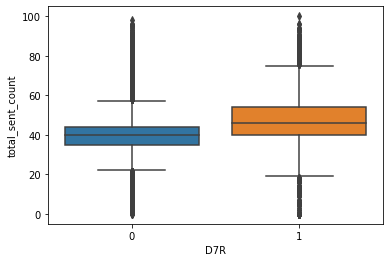

In [84]:
sns.boxplot(x='D7R', y='total_sent_count', data = df_new)

In [85]:
# sns.boxplot(x='D7R', y='total_open_count', data = df_new[df_new.total_open_count < 40])

In [86]:
df_new.iloc[:,1:12]

,total_sent_count,SCIENCE,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush
0,46.0,3,4,1,0,19.0,13.0,3,27.0,19.0,0
1,31.0,0,2,1,0,12.0,5.0,1,24.0,7.0,0
2,33.0,0,2,2,0,13.0,5.0,1,25.0,8.0,0
3,36.0,2,2,2,0,14.0,6.0,1,28.0,8.0,0
4,40.0,1,3,1,3,16.0,7.0,1,26.0,11.0,3
...,...,...,...,...,...,...,...,...,...,...,...
77197,45.0,2,2,0,0,27.0,6.0,0,24.0,21.0,0
77198,36.0,2,2,0,0,20.0,5.0,0,19.0,16.0,1
77199,5.0,0,0,0,0,2.0,1.0,0,3.0,2.0,0
77200,42.0,1,0,0,0,24.0,8.0,0,23.0,19.0,0


In [87]:
df_new.isnull().sum()

user_id             0
total_sent_count    0
SCIENCE             0
BIZ                 0
TECH                0
SPORTS              0
POLITICS            0
NATIONAL            0
UNKNOWN             0
scheduled           0
breaking            0
targetedPush        0
D7R                 0
dtype: int64

In [88]:
# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor()
# feature_size = [0.2, .3, .4, .5, .6, .7, .8, .9]
# cross_val_scores = []
# for size in feature_size:
#     rf.set_params(max_features = size)
#     rf.set_params(n_estimators=40)
#     rf.set_params(random_state=2019)
#     scores = cross_val_score(estimator = rf, X=df_new.iloc[:,1:13], y=df_new.D7R, cv=10)
#     cross_val_scores.append((np.mean(scores), size))
# cross_val_scores

In [89]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.set_params(max_features = 0.4)
rf.set_params(n_estimators=40)
scores = cross_val_score(estimator = rf, X=df_new.iloc[:,2:12], y=df_new.D7R, cv=10)
scores

array([0.83527584, 0.83354922, 0.82642487, 0.83303109, 0.83277202,
       0.83018135, 0.8238342 , 0.83056995, 0.83601036, 0.82797927])

In [90]:
scores.mean()

0.8309628166882053

In [91]:
rf.fit(df_new.iloc[:,2:12], df_new.D7R)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [92]:
importances = pd.DataFrame({
    'variable': df_new.fillna(0).iloc[:,2:12].columns,
    'Weight': rf.feature_importances_
})
importances.sort_values(by='Weight',ascending=False)

,variable,Weight
9,targetedPush,0.284234
4,POLITICS,0.135157
5,NATIONAL,0.120757
7,scheduled,0.098920
8,breaking,0.086640
0,SCIENCE,0.069503
1,BIZ,0.068995
6,UNKNOWN,0.052712
3,SPORTS,0.047376
2,TECH,0.035707


### TP highest, probably because getting sent more means you used the app more. Going to get rid of TP from model. 

In [93]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.set_params(max_features = 0.4)
rf.set_params(n_estimators=40)
scores = cross_val_score(estimator = rf, X=df_new.iloc[:,2:12], y=df_new.D7R, cv=10)
scores

array([0.83359233, 0.83134715, 0.8246114 , 0.83173575, 0.83316062,
       0.83264249, 0.82474093, 0.83160622, 0.83316062, 0.82953368])

In [94]:
scores.mean()

0.8306131193695961

In [95]:
rf.fit(df_new.iloc[:,2:11], df_new.D7R)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [96]:
importances = pd.DataFrame({
    'variable': df_new.fillna(0).iloc[:,2:11].columns,
    'Weight': rf.feature_importances_
})
importances.sort_values(by='Weight',ascending=False)

,variable,Weight
4,POLITICS,0.197631
5,NATIONAL,0.169156
7,scheduled,0.128704
8,breaking,0.108424
1,BIZ,0.100539
0,SCIENCE,0.094706
3,SPORTS,0.077983
6,UNKNOWN,0.068337
2,TECH,0.054520


### Going to try adding ratio of hard news (Politics and National) as a feature

In [97]:
df_new.head()

,user_id,total_sent_count,SCIENCE,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush,D7R
0,113517045,46.0,3,4,1,0,19.0,13.0,3,27.0,19.0,0,0
1,113119035,31.0,0,2,1,0,12.0,5.0,1,24.0,7.0,0,0
2,113100545,33.0,0,2,2,0,13.0,5.0,1,25.0,8.0,0,0
3,113012915,36.0,2,2,2,0,14.0,6.0,1,28.0,8.0,0,0
4,113328335,40.0,1,3,1,3,16.0,7.0,1,26.0,11.0,3,0


In [98]:
(df_new.POLITICS + df_new.NATIONAL)/df_new.iloc[:,2:9].sum(axis=1)

0        0.744186
1        0.809524
2        0.782609
3        0.740741
4        0.718750
           ...   
77197    0.891892
77198    0.862069
77199    1.000000
77200    0.969697
77201    0.837838
Length: 77202, dtype: float64

In [99]:
df_new['ratio_hard_news'] = (df_new.POLITICS + df_new.NATIONAL)/df_new.iloc[:,2:9].sum(axis=1)

In [100]:
df_new.head()

,user_id,total_sent_count,SCIENCE,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush,D7R,ratio_hard_news
0,113517045,46.0,3,4,1,0,19.0,13.0,3,27.0,19.0,0,0,0.744186
1,113119035,31.0,0,2,1,0,12.0,5.0,1,24.0,7.0,0,0,0.809524
2,113100545,33.0,0,2,2,0,13.0,5.0,1,25.0,8.0,0,0,0.782609
3,113012915,36.0,2,2,2,0,14.0,6.0,1,28.0,8.0,0,0,0.740741
4,113328335,40.0,1,3,1,3,16.0,7.0,1,26.0,11.0,3,0,0.718750


In [101]:
df_new['ratio_hard_news'] = df_new.ratio_hard_news.fillna(0)

In [102]:
df_X = df_new[['total_sent_count','SCIENCE', 'BIZ', 'TECH', 'SPORTS','POLITICS', 'NATIONAL', 'UNKNOWN', 'scheduled', 'breaking']]

In [103]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.set_params(max_features = 0.4)
rf.set_params(n_estimators=40)
scores = cross_val_score(estimator = rf, X=df_X, y=df_new.D7R, cv=10)
scores

array([0.83087283, 0.82784974, 0.82901554, 0.83354922, 0.83264249,
       0.83549223, 0.82253886, 0.82966321, 0.83238342, 0.82629534])

In [104]:
scores.mean()

0.8300302882686303

In [105]:
rf.fit(df_X, df_new.D7R)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [106]:
importances = pd.DataFrame({
    'variable': df_X.columns,
    'Weight': rf.feature_importances_
})
importances.sort_values(by='Weight',ascending=False)

,variable,Weight
0,total_sent_count,0.257319
5,POLITICS,0.136561
6,NATIONAL,0.123423
9,breaking,0.094717
8,scheduled,0.094347
2,BIZ,0.077105
1,SCIENCE,0.072795
7,UNKNOWN,0.053821
4,SPORTS,0.050551
3,TECH,0.039362


### Total sent count unsurprisingly the biggest factor. Breaking and scheduled are the same importance?

In [107]:
pd.Series(rf.predict(df_X))

0        0
1        0
2        0
3        0
4        0
        ..
77197    0
77198    0
77199    0
77200    0
77201    0
Length: 77202, dtype: int64

### Creating training and test set to test out prediction

In [108]:
df_new['is_train'] = np.random.uniform(0, 1, len(df_new)) <= .75

In [109]:
train, test = df_new[df_new['is_train']==True], df_new[df_new['is_train']==False]

In [110]:
X_train = train[['total_sent_count',
            'SCIENCE', 'BIZ', 'TECH', 'SPORTS','POLITICS', 'NATIONAL', 'UNKNOWN', 'scheduled', 'breaking']]

In [111]:
rf.fit(X_train, train.D7R)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [113]:
X_test = test[['total_sent_count',
            'SCIENCE', 'BIZ', 'TECH', 'SPORTS','POLITICS', 'NATIONAL', 'UNKNOWN', 'scheduled', 'breaking']]

In [114]:
test = test.copy()

In [115]:
rf.score(X_test, test.D7R)

0.8231193424201436

In [116]:
test['prediction'] = rf.predict(X_test)

In [117]:
test.head()

,user_id,total_sent_count,SCIENCE,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush,D7R,ratio_hard_news,is_train,prediction
0,113517045,46.0,3,4,1,0,19.0,13.0,3,27.0,19.0,0,0,0.744186,False,0
2,113100545,33.0,0,2,2,0,13.0,5.0,1,25.0,8.0,0,0,0.782609,False,0
10,110545485,32.0,1,1,0,0,13.0,11.0,3,24.0,8.0,0,0,0.827586,False,0
17,110438125,37.0,4,2,0,0,16.0,11.0,1,27.0,10.0,0,1,0.794118,False,0
18,110189755,3.0,0,0,0,0,2.0,0.0,0,2.0,1.0,0,0,1.000000,False,0


In [118]:
np.mean(test.prediction == test.D7R)

0.8231193424201436

In [119]:
test['prediction_naive'] = 0

In [120]:
np.mean(test.prediction_naive == test.D7R)

0.8338362293205702

### 83% success rate with simple model that has total sent count sum, by category and by type. Not great, considering assigning every user as not retained would have an ~83% success rate with 16% D7RR

## Calculating F1 score

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [131]:
X = df_new[['total_sent_count',
            'SCIENCE', 'BIZ', 'TECH', 'SPORTS','POLITICS', 'NATIONAL', 'UNKNOWN', 'scheduled', 'breaking']]

In [132]:
y = df_new.D7R

In [133]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)

In [134]:
?rf

In [135]:
rf.fit(trainX, trainy)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [141]:
rf_probs = rf.predict_proba(testX)
#getting just the positive predictions for lr_probs
rf_probs = rf_probs[:, 1]
yhat = rf.predict(testX)
rf_precision, rf_recall, _ = precision_recall_curve(testy, lr_probs)
rf_f1, rf_auc = f1_score(testy, yhat), auc(rf_recall, rf_precision)
print('Logistic: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))

Logistic: f1=0.312 auc=0.379


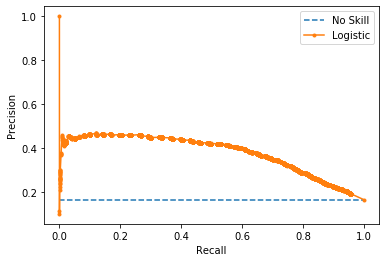

In [142]:
no_skill = len(testy[testy==1]) / len(testy)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill');
plt.plot(rf_recall, rf_precision, marker='.', label='Logistic');
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

### Looks OK? Not sure how to interpret

## More Data Exploration

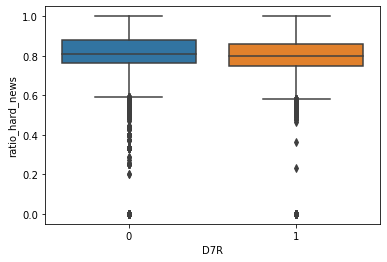

In [124]:
sns.boxplot(y ='ratio_hard_news', x = 'D7R', data=df_new)

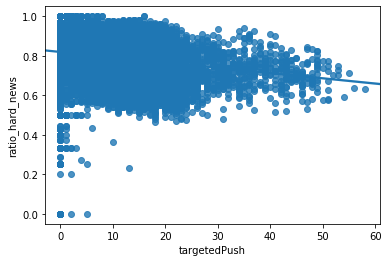

In [125]:
sns.regplot(y ='ratio_hard_news', x = 'targetedPush', data=df_new)

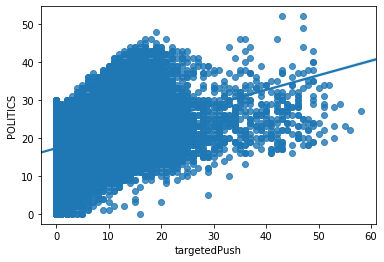

In [126]:
sns.regplot(y ='POLITICS', x = 'targetedPush', data=df_new)

In [127]:
df_new.head()

,user_id,total_sent_count,SCIENCE,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush,D7R,ratio_hard_news,is_train
0,113517045,46.0,3,4,1,0,19.0,13.0,3,27.0,19.0,0,0,0.744186,False
1,113119035,31.0,0,2,1,0,12.0,5.0,1,24.0,7.0,0,0,0.809524,True
2,113100545,33.0,0,2,2,0,13.0,5.0,1,25.0,8.0,0,0,0.782609,False
3,113012915,36.0,2,2,2,0,14.0,6.0,1,28.0,8.0,0,0,0.740741,True
4,113328335,40.0,1,3,1,3,16.0,7.0,1,26.0,11.0,3,0,0.718750,True


In [128]:
pd.concat([df_new.iloc[:,1:12], df_new.ratio_hard_news], axis=1).corr()

,total_sent_count,SCIENCE,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush,ratio_hard_news
total_sent_count,1.000000,0.526927,0.440746,0.188409,0.247840,0.840514,0.704388,0.305637,0.841365,0.800101,0.583765,-0.082950
SCIENCE,0.526927,1.000000,0.167932,0.078214,0.098932,0.482741,0.370688,0.182229,0.479519,0.426910,0.262682,-0.220582
BIZ,0.440746,0.167932,1.000000,0.236983,0.086503,0.149266,0.369814,0.367585,0.381464,0.182731,0.391441,-0.428133
TECH,0.188409,0.078214,0.236983,1.000000,0.049841,-0.009750,0.107750,0.334232,0.177189,0.007173,0.212545,-0.351325
SPORTS,0.247840,0.098932,0.086503,0.049841,1.000000,0.086248,0.130165,0.078943,0.064870,0.071351,0.413977,-0.214361
POLITICS,0.840514,0.482741,0.149266,-0.009750,0.086248,1.000000,0.388572,0.041792,0.717275,0.863131,0.315586,0.157553
NATIONAL,0.704388,0.370688,0.369814,0.107750,0.130165,0.388572,1.000000,0.508554,0.615093,0.428379,0.502349,-0.106598
UNKNOWN,0.305637,0.182229,0.367585,0.334232,0.078943,0.041792,0.508554,1.000000,0.383956,0.051513,0.202879,-0.433670
scheduled,0.841365,0.479519,0.381464,0.177189,0.064870,0.717275,0.615093,0.383956,1.000000,0.688932,0.151858,-0.130936
breaking,0.800101,0.426910,0.182731,0.007173,0.071351,0.863131,0.428379,0.051513,0.688932,1.000000,0.140281,0.135193


In [129]:
df_new.iloc[:,1:14].corr()

,total_sent_count,SCIENCE,BIZ,TECH,SPORTS,POLITICS,NATIONAL,UNKNOWN,scheduled,breaking,targetedPush,D7R,ratio_hard_news
total_sent_count,1.000000,0.526927,0.440746,0.188409,0.247840,0.840514,0.704388,0.305637,0.841365,0.800101,0.583765,0.269088,-0.082950
SCIENCE,0.526927,1.000000,0.167932,0.078214,0.098932,0.482741,0.370688,0.182229,0.479519,0.426910,0.262682,0.119566,-0.220582
BIZ,0.440746,0.167932,1.000000,0.236983,0.086503,0.149266,0.369814,0.367585,0.381464,0.182731,0.391441,0.151761,-0.428133
TECH,0.188409,0.078214,0.236983,1.000000,0.049841,-0.009750,0.107750,0.334232,0.177189,0.007173,0.212545,0.091068,-0.351325
SPORTS,0.247840,0.098932,0.086503,0.049841,1.000000,0.086248,0.130165,0.078943,0.064870,0.071351,0.413977,0.153139,-0.214361
POLITICS,0.840514,0.482741,0.149266,-0.009750,0.086248,1.000000,0.388572,0.041792,0.717275,0.863131,0.315586,0.186180,0.157553
NATIONAL,0.704388,0.370688,0.369814,0.107750,0.130165,0.388572,1.000000,0.508554,0.615093,0.428379,0.502349,0.175285,-0.106598
UNKNOWN,0.305637,0.182229,0.367585,0.334232,0.078943,0.041792,0.508554,1.000000,0.383956,0.051513,0.202879,0.085449,-0.433670
scheduled,0.841365,0.479519,0.381464,0.177189,0.064870,0.717275,0.615093,0.383956,1.000000,0.688932,0.151858,0.143637,-0.130936
breaking,0.800101,0.426910,0.182731,0.007173,0.071351,0.863131,0.428379,0.051513,0.688932,1.000000,0.140281,0.104401,0.135193


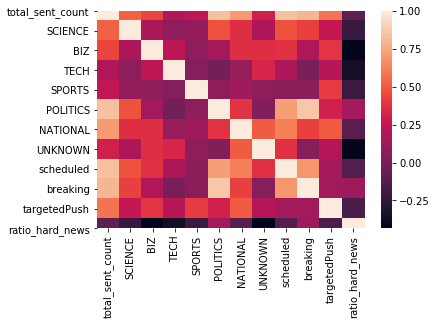

In [130]:
sns.heatmap(pd.concat([df_new.iloc[:,1:12], df_new.ratio_hard_news], axis=1).corr())

### Targeted Pushes are too biased. You get sent more BECAUSE you are a more engaged user. Going to make a new sheet without tatgeted pushes. You also get lower ratio of hard-news pushes BECAUSE you are a more engaged user

New model=
1) only scheduled and breaking, no targeted
2) D0 through D6 sent count
3) ratio of hard new to soft news (counting personalized push)
4) time difference between first closing the app and sending first push
5) D7 plus whether they were in 5 weeks after installing

New model over here: https://jupyter.smartnews.be/user/sn/notebooks/push-notification/2020-01-02-DEVON-PUSH-new_user_activation_project-PART-2.ipynb